# <center>Deep Learning Assignment 1</center>

### Setting up the Notebook

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import shutil
import tempfile


In [2]:
print(f'Default GPU Device:{tf.test.gpu_device_name()}')

Default GPU Device:/device:GPU:0


In [3]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Open an embedded TensorBoard viewer
%tensorboard --logdir {logdir}/models

### Exploratory Data Analysis

In [4]:
data = pd.read_csv("data.csv")

In [5]:
data.head(5)

,View1,View2,View3,View4,label
0,Image_000001_001.jpg,Image_000001_002.jpg,Image_000001_003.jpg,Image_000001_004.jpg,airplane
1,Image_000002_001.jpg,Image_000002_002.jpg,Image_000002_003.jpg,Image_000002_004.jpg,airplane
2,Image_000003_001.jpg,Image_000003_002.jpg,Image_000003_003.jpg,Image_000003_004.jpg,airplane
3,Image_000004_001.jpg,Image_000004_002.jpg,Image_000004_003.jpg,Image_000004_004.jpg,airplane
4,Image_000005_001.jpg,Image_000005_002.jpg,Image_000005_003.jpg,Image_000005_004.jpg,airplane


In [6]:
data.shape

(30530, 5)

* 4 images per view for each label

In [7]:
last_column = data["label"]
print(f"There are {len(last_column.unique())} classes for this dataset")

There are 20 classes for this dataset


Plot the data distribution 

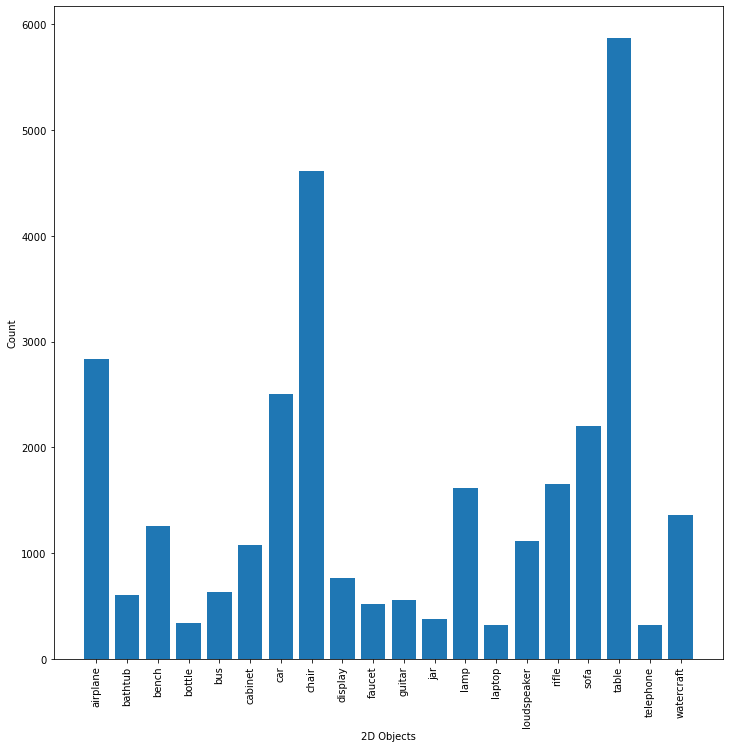

In [8]:
labels, counts = np.unique(last_column, return_counts=True)
plt.figure(figsize=(12, 12))
plt.bar(labels, counts, align='center', )
plt.xlabel('2D Objects')
plt.ylabel('Count')
plt.xticks(rotation='vertical')
plt.show()

* unbalanced data distrubtion across the 20 classes
* classes such as car and table which has much more data points than rest of the classes

In [9]:
result = [x for x in data['View1']]
len(result)

30530

In [10]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2)

In [11]:
c = []
for index, row in data.iterrows():
    c.append([row['View1'], row['View2']])



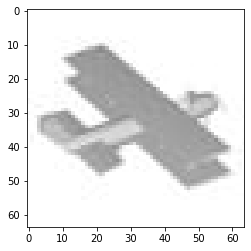

In [12]:
from PIL import Image
data = Image.open("data/Train/Image_000001_001.jpg")
plt.imshow(data)

In [13]:
np.array(data).shape

(64, 64, 3)

In [21]:
c = [Image.open("data/Train/" + x).convert('L') for x in train.iloc[45] if x != train.iloc[45]['label']]
c

[<PIL.Image.Image image mode=L size=64x64 at 0x23EEDE46A00>,
 <PIL.Image.Image image mode=L size=64x64 at 0x23EEDE46430>,
 <PIL.Image.Image image mode=L size=64x64 at 0x23EEDE46C10>,
 <PIL.Image.Image image mode=L size=64x64 at 0x23EEDE46250>]

In [22]:
# images = [Image.open(f) for f in c]
images = [np.asarray(image) for image in c]
images = [np.expand_dims(image, axis=-1) for image in images]

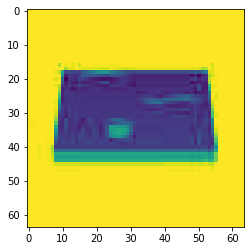

In [23]:
plt.imshow(images[1])

Plot list of images

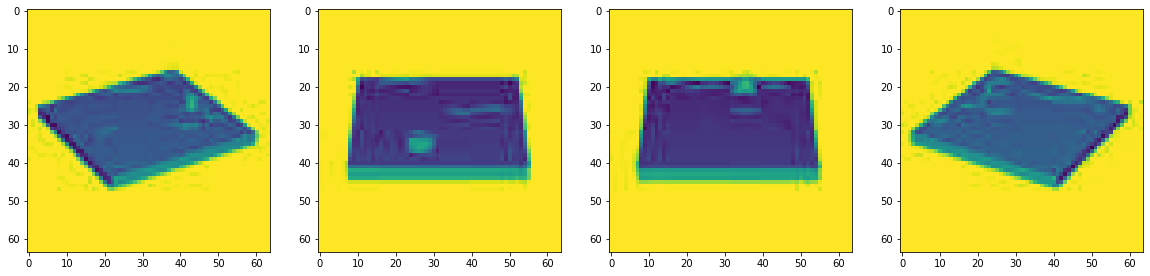

In [24]:
fig = plt.figure(figsize=(20, 20))

for i in range(0, 4):
    fig.add_subplot(1, 4, i + 1)
    plt.imshow(c[i])


### Custom Data Loader for this Assignment

In [25]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
class CustomDataLoader(tf.keras.utils.Sequence):
    def __init__(self, dataFrame, batch_size, labels, shuffle, augment, std, mean ,data_prefix="", dim=(4, 64, 64, 3)):
        self.batch_size = batch_size
        self.labels = labels
        self.augment = augment
        self.dim = dim
       
        self.dataFrame = dataFrame.copy()
        self.image_label = dataFrame['label'].values.tolist()
        self.image_ids = np.arange(len(self.image_label)).tolist()
        self.data_prefix = data_prefix
        self.shuffle = shuffle

        self.std = std
        self.mean = mean

        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_ids) / self.batch_size))

    def __getitem__(self, index):
        idx = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        data_ids_temp = [self.image_ids[k] for k in idx]
        image_label_temp = [self.image_label[k] for k in idx]
        image_label_temp =  le.fit_transform(image_label_temp)
        # Generate data
        X, y = self.__data_generation(data_ids_temp, image_label_temp)

        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_ids))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)


    def __data_generation(self,  data_ids_temp, image_label_temp):

        X = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size))
        
        for i, ids in enumerate(data_ids_temp):
            X[i, ]  = self.__read_data_instance(data_ids_temp[i])
            y[i] = image_label_temp[i]

        return X, tf.keras.utils.to_categorical(y, num_classes=self.labels)
    

    def __read_data_instance(self, pid):
        filePaths = [self.data_prefix + x for x in train.iloc[pid] if x != train.iloc[pid]['label']]
        
        images = [Image.open(f) for f in filePaths]
        images = [np.asarray(image) for image in images]
        # images = [np.expand_dims(image, axis=-1) for image in images]
        
        X = [(image - self.mean) / self.std for image in images]

        return X
        

In [26]:
mean = 0
std = 255.0

prefix = 'data/Train/'
train_g = CustomDataLoader(train, batch_size=64, mean=0, std=std, labels=20, data_prefix=prefix, shuffle=True, augment=False)

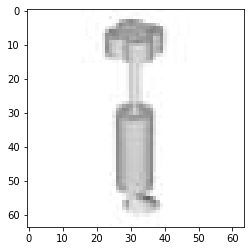

In [27]:
x, y =next(train_g.__iter__())
plt.imshow(x[0][0])

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda, Input, MaxPooling3D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import regularizers, optimizers

def get_model():
  model_cnn = Sequential()

  # input
  model_cnn.add(Input(shape=(4, 64,64, 3)))

  # Conv Layer 1
  model_cnn.add(Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(0.001)))
  model_cnn.add(Activation('relu'))
  model_cnn.add(MaxPooling3D(pool_size=(2, 2, 2)))

  # Conv Layer 2 (no pooling)
  model_cnn.add(Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(0.001)))
  model_cnn.add(Activation('relu'))

  # Conv Layer 3
  model_cnn.add(Conv2D(64, (3, 3)))
  model_cnn.add(Activation('relu'))
  model_cnn.add(MaxPooling3D(pool_size=(2, 2,2 )))

  # MLP
  # this converts our 3D feature maps to 1D feature vectors
  model_cnn.add(Flatten())
  model_cnn.add(Dropout(0.5))
  model_cnn.add(Dense(64))
  model_cnn.add(Activation('relu'))
  #model_cnn.add(Dropout(0.5))
  model_cnn.add(Dense(20))
  model_cnn.add(Activation('softmax'))

  return model_cnn


In [33]:
from itertools import cycle


def plotter(history_hold, metric='binary_crossentropy', ylim=[0.0, 1.0]):
  cycol = cycle('bgrcmk')
  for name, item in history_hold.items():
    y_train = item.history[metric]
    y_val = item.history['val_' + metric]
    x_train = np.arange(0, len(y_val))

    c = next(cycol)

    plt.plot(x_train, y_train, c+'-', label=name+'_train')
    plt.plot(x_train, y_val, c+'--', label=name+'_val')

  plt.legend()
  plt.xlim([1, max(plt.xlim())])
  plt.ylim(ylim)
  plt.xlabel('Epoch')
  plt.ylabel(metric)
  plt.grid(True)


In [34]:
model2 = get_model()
model2.summary()

model2.compile(optimizer=tf.keras.optimizers.Adam(),
               loss=tf.losses.CategoricalCrossentropy(),
               metrics=[tf.losses.CategoricalCrossentropy(name='CategoricalCrossentropy'), 'categorical_accuracy'])




Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 4, 62, 62, 32)     896       
                                                                 
 activation_5 (Activation)   (None, 4, 62, 62, 32)     0         
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 2, 31, 31, 32)    0         
 3D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 2, 29, 29, 32)     9248      
                                                                 
 activation_6 (Activation)   (None, 2, 29, 29, 32)     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 2, 27, 27, 64)     18496     
                                                      

In [35]:
model2.fit(train_g, epochs=10, verbose=0)
